# Task 29-> Hyperparameter Tuning Techniques

## Introduction to Hyperparameters and Their Importance

In machine learning, hyperparameters are external configurations that control the training process of a model. Unlike model parameters (e.g., weights in neural networks), which are learned from the data, hyperparameters are set before training and dictate how the learning process occurs. Proper tuning of these hyperparameters is critical because it can significantly influence the model's performance, ensuring it generalizes well to unseen data.

### Parameters vs. Hyperparameters

Parameters: Values within the model that are learned from the training data (e.g., weights in neural networks, coefficients in linear regression).
Hyperparameters: External configurations set before the learning process begins (e.g., learning rate, number of trees in a random forest, kernel type in SVM).
##  Overview of Hyperparameter Tuning Techniques

Hyperparameter tuning involves searching for the optimal hyperparameters that maximize the model's performance. Common techniques include:
<br>
### 1. Grid Search <br>
### 2. Randomized Search <br>
### 3. Bayesian Optimization <br>
### 4. Genetic Algorithms <br>
### 5. Early Stopping <br>
### 6. Ensemble Method <br>
Each of these methods has its strengths and weaknesses, which makes them suitable for different scenarios depending on the complexity of the model, the dataset size, and computational resources.

## Importing Necessary Files

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from tpot import TPOTClassifier
import xgboost as xgb
from skopt import Optimizer
from skopt.plots import plot_convergence

## Load the Titanic dataset

In [2]:
df = pd.read_csv('/kaggle/input/titanic-dataset/Titanic-Dataset.csv')
print(f"Dataset loaded. Shape: {df.shape}")

Dataset loaded. Shape: (891, 12)


## First 5 Rows of dataset

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature engineering
Properly examined each feature to accurately categorize the features.

In [4]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
df['Title'] = df['Title'].replace('Mlle', 'Miss')
df['Title'] = df['Title'].replace('Ms', 'Miss')
df['Title'] = df['Title'].replace('Mme', 'Mrs')
df['Title'] = df['Title'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5})
df['Title'] = df['Title'].fillna(0)
df['FareBin'] = pd.qcut(df['Fare'], 4)
df['AgeBin'] = pd.cut(df['Age'].fillna(-1), 5)

## Checking for Missing Values

In [5]:
print("\nMissing values before preprocessing:")
print(df.isnull().sum())


Missing values before preprocessing:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
dtype: int64


## Handling missing values

In [6]:
print("\nHandling missing values...")
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
df['Fare'] = df['Fare'].fillna(df['Fare'].median())
df['Has_Cabin'] = df['Cabin'].notna().astype(int)
df = df.drop('Cabin', axis=1)
df = df.dropna()

print("\nMissing values after preprocessing:")
print(df.isnull().sum())


Handling missing values...

Missing values after preprocessing:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
FamilySize     0
IsAlone        0
Title          0
FareBin        0
AgeBin         0
Has_Cabin      0
dtype: int64


## Preprocess the dataset


In [7]:
X = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Survived'])
y = df['Survived']
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

## Identify categorical and numerical columns


In [8]:
categorical_cols = ['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin']
numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']

## Label Encoding for categorical columns


In [9]:
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

## Split the dataset into training and testing sets


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Standardize numerical features


In [11]:
scaler = StandardScaler()


In [12]:
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (712, 13)
Testing set shape: (179, 13)


# 1. Grid Search
Grid Search is one of the simplest and most exhaustive methods for hyperparameter tuning. It works by defining a grid of hyperparameter values and evaluating every possible combination.

## How Grid Search Works
### Step 1: 
Define the hyperparameter grid, a dictionary where each key is a hyperparameter name, and the value is a list of possible values for that hyperparameter.
### Step 2: 
Systematically train and evaluate the model using cross-validation for every possible combination in the grid.
### Step 3: 
The combination that yields the best cross-validation performance is selected as the optimal set of hyperparameters.
## Pros and Cons of Grid Search
### Advantages:
Ensures that the best combination within the defined grid is found.
Simple and straightforward to implement.
### Disadvantages:
Computationally expensive, especially when the grid is large or the model is complex.
The search space grows exponentially with the number of hyperparameters.
## When to Use Grid Search
Suitable for small datasets and simpler models where the search space is limited.
Effective when you have a clear idea of the potential values of hyperparameters.

In [13]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Changed 'auto' to 'sqrt'
}

In [14]:
grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                           param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best Parameters from Grid Search:", grid_search.best_params_)
print("Best Score from Grid Search:", grid_search.best_score_)

Best Parameters from Grid Search: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best Score from Grid Search: 0.8314094356347876


## Feature importance for best model from Grid Search


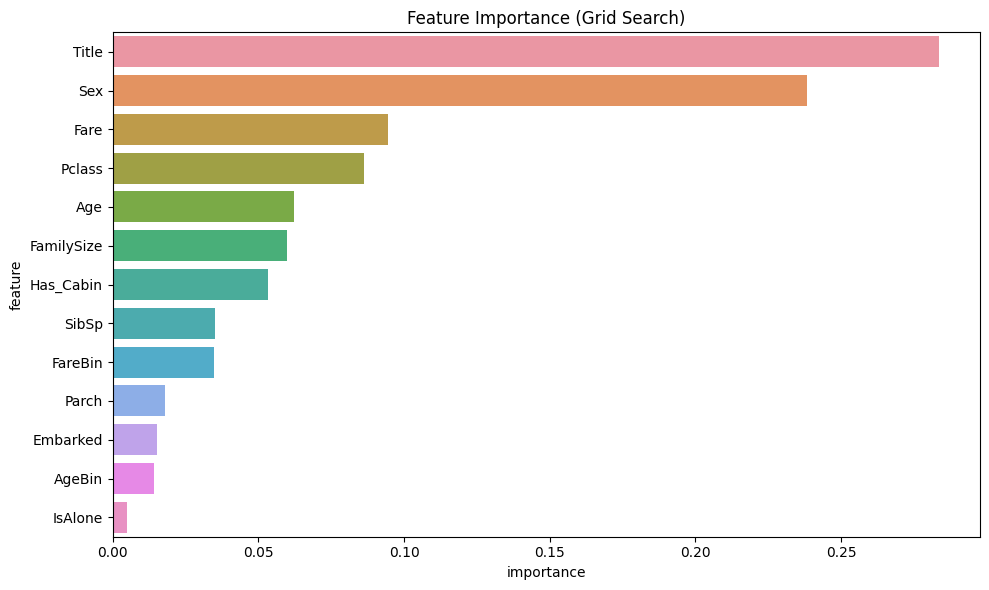

In [15]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': grid_search.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Grid Search)')
plt.tight_layout()
plt.show()

# 2. Random Search
Randomized Search is an alternative to Grid Search that samples a fixed number of hyperparameter combinations from specified distributions. This method is particularly useful when dealing with a large number of hyperparameters or when the search space is vast.

## How Randomized Search Works
### Step 1: 
Define distributions or ranges for each hyperparameter.
### Step 2: 
Randomly sample a fixed number of hyperparameter combinations from these distributions.
### Step 3: 
Train and evaluate the model using cross-validation for each sampled combination.
### Step 4: 
The combination that yields the best cross-validation performance is selected as the optimal set of hyperparameters.
## Pros and Cons of Randomized Search
### Advantages:
More efficient than Grid Search for large search spaces.
Can discover good hyperparameters quickly without exhaustive searching.
### Disadvantages:
Does not guarantee finding the absolute best combination.
Results can vary depending on the random seed used.
## When to Use Randomized Search
Ideal for complex models with many hyperparameters.
Useful when the search space is large and computational resources are limited.


In [16]:
param_dist = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, num=10)],
    'max_depth': [int(x) for x in np.linspace(5, 50, num=10)],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  # Changed 'auto' to 'sqrt'
}

In [17]:
random_search = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print("Best Parameters from Random Search:", random_search.best_params_)
print("Best Score from Random Search:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=45, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=45, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=45, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s[CV] END max_depth=45, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s

[CV] END max_depth=45, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=400; total time=   1.3s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=4

## Feature importance for best model from Random Search


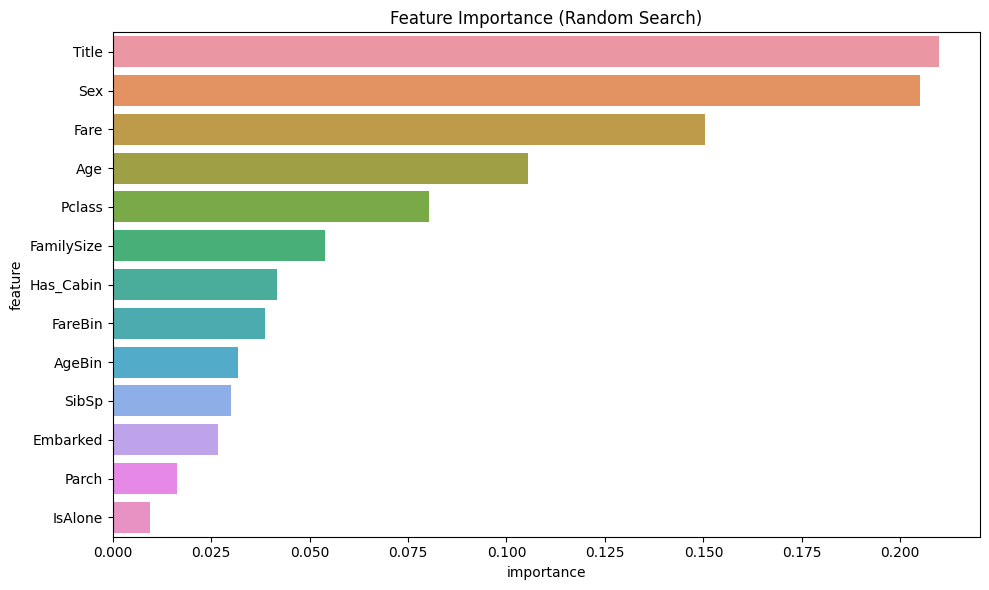

In [18]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': random_search.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Random Search)')
plt.tight_layout()
plt.show()

# 3. Bayesian Optimization
Bayesian Optimization is a more sophisticated method that builds a probabilistic model of the objective function and uses this model to select the most promising hyperparameters.

## How Bayesian Optimization Works
### Step 1: 
Define a probabilistic surrogate model, typically a Gaussian Process, to model the objective function.
### Step 2: 
Use an acquisition function to decide the next set of hyperparameters to evaluate based on the surrogate model.
### Step 3: 
Update the surrogate model with the results from the latest evaluation.
### Step 4: 
Repeat steps 2 and 3 until convergence or until a set number of evaluations is reached.
## Pros and Cons of Bayesian Optimization
### Advantages:
More efficient than Grid and Randomized Search because it focuses on promising areas of the search space.
Well-suited for expensive evaluations where each training run is costly.
### Disadvantages:
More complex to implement.
May require significant tuning of the surrogate model and acquisition function.
## When to Use Bayesian Optimization
Suitable for expensive models where each evaluation is costly (e.g., deep learning models).
Effective when the search space is large, and you need to minimize the number of evaluations.

In [19]:
param_space = {
    'n_estimators': Integer(100, 1000),
    'max_depth': Integer(5, 50),
    'min_samples_split': Integer(2, 10),
    'min_samples_leaf': Integer(1, 4),
    'max_features': Categorical(['sqrt', 'log2'])  # Changed 'auto' to 'sqrt'
}

In [20]:
bayes_search = BayesSearchCV(estimator=RandomForestClassifier(random_state=42),
                             search_spaces=param_space, n_iter=50, cv=5, n_jobs=-1, random_state=42)
bayes_search.fit(X_train, y_train)

print("Best Parameters from Bayesian Optimization:", bayes_search.best_params_)
print("Best Score from Bayesian Optimization:", bayes_search.best_score_)

Best Parameters from Bayesian Optimization: OrderedDict([('max_depth', 5), ('max_features', 'log2'), ('min_samples_leaf', 2), ('min_samples_split', 6), ('n_estimators', 105)])
Best Score from Bayesian Optimization: 0.8313897370235399


## Feature importance for best model from Bayesian Optimization


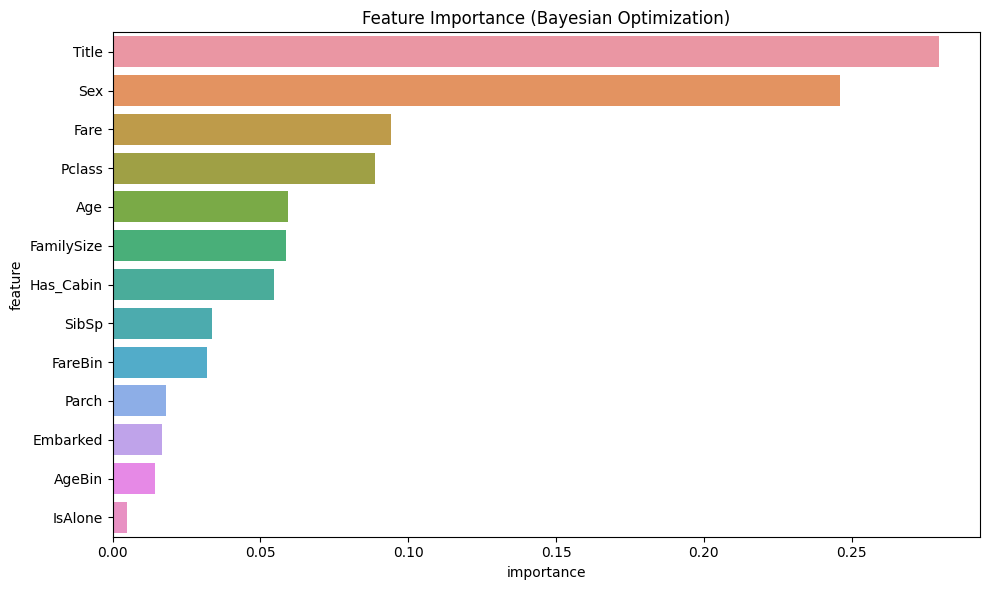

In [21]:
feature_importance = pd.DataFrame({'feature': X.columns, 'importance': bayes_search.best_estimator_.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance (Bayesian Optimization)')
plt.tight_layout()
plt.show()

# 4. Genetic Algorithm (TPOT)
Genetic Algorithms are inspired by the process of natural selection. They use concepts such as mutation, crossover, and selection to evolve a population of candidate solutions.

## How Genetic Algorithms Work
### Step 1: 
Initialize a population of hyperparameter sets randomly.
### Step 2: 
Evaluate each set in the population.
### Step 3: 
Select the best-performing sets (parents) and use crossover and mutation to generate new sets (offspring).
### Step 4: 
Repeat the process until a termination criterion is met (e.g., a set number of generations or convergence).
## Pros and Cons of Genetic Algorithms
### Advantages:
Capable of exploring a large and complex search space.
Does not require the search space to be differentiable.
### Disadvantages:
Computationally expensive and may require tuning of algorithm-specific hyperparameters (e.g., mutation rate, population size).
May not always converge to the global optimum.
## When to Use Genetic Algorithms
Useful when other optimization methods fail or when the search space is non-continuous or irregular.
Suitable for problems where there is a large and complex hyperparameter space.

In [22]:
tpot = TPOTClassifier(generations=5, population_size=50, cv=5, random_state=42, verbosity=2, n_jobs=-1)
tpot.fit(X_train, y_train)

print("Best Pipeline identified by Genetic Algorithm:")
print(tpot.fitted_pipeline_)
print("TPOT Best Model Accuracy:", tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8300009849305624

Generation 2 - Current best internal CV score: 0.8328080370333891

Generation 3 - Current best internal CV score: 0.8328080370333891

Generation 4 - Current best internal CV score: 0.8328277356446371

Generation 5 - Current best internal CV score: 0.8328277356446371

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=0.5, verbosity=0)
Best Pipeline identified by Genetic Algorithm:
Pipeline(steps=[('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=

Bascically it uses ramdom forest mostly so we cannot draw feature importance plot in it.

# 5. XGBoost with Early Stopping
Early Stopping is a technique where training is halted when the model’s performance on a validation set stops improving, thereby preventing overfitting.

## How Early Stopping Works
### Step 1: 
Monitor the performance of the model on a validation set during training.
### Step 2: 
Stop training when the performance on the validation set no longer improves for a predefined number of epochs (patience).
### Step 3: 
The model state that yielded the best validation performance is restored.
## Pros and Cons of Early Stopping
### Advantages:
Reduces the risk of overfitting.
Saves computational resources by avoiding unnecessary training.
### Disadvantages:
Requires careful tuning of the patience parameter.
May stop training too early if the validation metric plateaus temporarily.
## When to Use Early Stopping
Commonly used in training deep learning models.
Effective when you need to balance model performance and computational efficiency.

In [23]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [24]:
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

In [25]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_boost_round=1000, evals=evallist, early_stopping_rounds=10)

[0]	eval-logloss:0.63571	train-logloss:0.61721
[1]	eval-logloss:0.60268	train-logloss:0.58371
[2]	eval-logloss:0.57317	train-logloss:0.55338
[3]	eval-logloss:0.54867	train-logloss:0.52826
[4]	eval-logloss:0.52929	train-logloss:0.50719
[5]	eval-logloss:0.51241	train-logloss:0.48939
[6]	eval-logloss:0.49905	train-logloss:0.47422
[7]	eval-logloss:0.48709	train-logloss:0.46127
[8]	eval-logloss:0.47671	train-logloss:0.44961
[9]	eval-logloss:0.46645	train-logloss:0.43976
[10]	eval-logloss:0.45932	train-logloss:0.43107
[11]	eval-logloss:0.45390	train-logloss:0.42379
[12]	eval-logloss:0.44629	train-logloss:0.41731
[13]	eval-logloss:0.44206	train-logloss:0.41145
[14]	eval-logloss:0.43837	train-logloss:0.40653
[15]	eval-logloss:0.43398	train-logloss:0.40209
[16]	eval-logloss:0.43165	train-logloss:0.39828
[17]	eval-logloss:0.43003	train-logloss:0.39463
[18]	eval-logloss:0.42824	train-logloss:0.39157
[19]	eval-logloss:0.42593	train-logloss:0.38874
[20]	eval-logloss:0.42504	train-logloss:0.38598
[2

In [26]:
y_pred = bst.predict(dtest)
y_pred_binary = [1 if y > 0.5 else 0 for y in y_pred]
accuracy = accuracy_score(y_test, y_pred_binary)
print("XGBoost Accuracy:", accuracy)

XGBoost Accuracy: 0.7988826815642458


## Plot feature importance for XGBoost


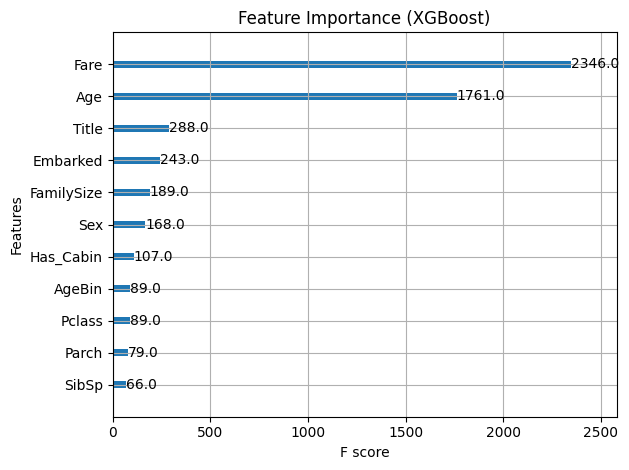

In [27]:
xgb.plot_importance(bst)
plt.title('Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

## 6. Ensemble Method: Combining Models for Better Predictions
The code provided demonstrates how to implement a Voting Classifier, a type of ensemble method that combines the predictions of multiple machine learning models to achieve better overall performance. In this case, the Voting Classifier combines three different models: a Random Forest, an XGBoost, and a Gradient Boosting Classifier. This method is particularly useful for improving accuracy and robustness in predictions.

### Voting Classifier Overview
The Voting Classifier is an ensemble technique that aggregates the predictions of multiple base models to produce a final prediction. The idea is that by combining different models, we can leverage their individual strengths and reduce the likelihood of errors that any single model might make.

## Types of Voting
### 1. Hard Voting: 
Each model casts a vote for a specific class. The class with the most votes is chosen as the final prediction.
### 2. Soft Voting: 
Each model predicts a probability distribution over the classes. The final prediction is based on the average of these predicted probabilities, often weighted by the model's accuracy or another criterion.

In [28]:
rf_best = grid_search.best_estimator_
xgb_best = xgb.XGBClassifier(max_depth=3, eta=0.1, n_estimators=bst.best_iteration)
gb_best = GradientBoostingClassifier(random_state=42)

In [29]:
ensemble = VotingClassifier(
    estimators=[('rf', rf_best), ('xgb', xgb_best), ('gb', gb_best)],
    voting='soft'
)

In [30]:
ensemble.fit(X_train, y_train)
ensemble_accuracy = ensemble.score(X_test, y_test)
print("Ensemble Model Accuracy:", ensemble_accuracy)

Ensemble Model Accuracy: 0.8491620111731844
